# Reading an IgorPro data file from the EPFL microcircuit database and saving in NWB format

## Install required packages

We install a development branch of Neo with preliminary support for Neurodata Without Borders (NWB) format.

In [1]:
%matplotlib inline

In [2]:
%%capture
!pip install https://github.com/apdavison/python-neo/archive/nwb.zip
!pip install igor

In [3]:
import requests
import random
import zipfile
import StringIO

import neo
print(neo.__version__)

0.5.0alpha1


## Get list of uncurated datasets from the BBP Microcircuit database

In [4]:
bbp_uncurated_url = "http://microcircuits.epfl.ch/data/uncurated.json"

In [5]:
uncurated = requests.get(bbp_uncurated_url).json()

In [6]:
print("{}\n\n{}".format(uncurated['title'], uncurated['introduction']['text']))

LNMC electrophysiological data archive

Over the past 20 years, the Markram Lab has captured thousands of traces characterising the electrical behavior of single cells, synaptic connections and groups of cells and brain regions. While documentation of this data is extensive, the layout of data and electronic meta data requires more work before it lives up to the curated data standards we are promoting. While data curation is often done prior to data release, we decided to make the uncurated data accessible to the community now. We hope that this inspires other in the community to open their data archives as well and join us in our journey to a more open, ultimately more accessible, neuroscience.


In [7]:
items = uncurated['data_table']['table']['rows']

In [8]:
items[0]

[u'<a href="/data/uncurated/sm100415a1_folder.zip">sm100415a1 Folder</a>',
 u'371',
 u'Muralidhar, Shruti']

## Select a random dataset and download it into memory

In [9]:
# we filter to try to ensure we get a dataset containing Igor Pro files
filtered_items = [item for item in items if "tkb" in item[0]]
folder = random.sample(filtered_items, 1)[0]
print(folder)

[u'<a href="/data/uncurated/tkb051018a2_folder.zip">tkb051018a2 Folder</a>', u'818', u'Berger, Thomas']


In [10]:
from HTMLParser import HTMLParser
class MyHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag == "a":
            for attr in attrs:
                if attr[0] == "href":
                    self.url = attr[1]

In [11]:
def get_zipfile(data_item):
    parser = MyHTMLParser()
    parser.feed(data_item[0])
    data_file_url = parser.url
    f = StringIO.StringIO()
    response = requests.get("http://microcircuits.epfl.ch" + data_file_url)
    f.write(response.content)
    return zipfile.ZipFile(f)

In [12]:
archive = get_zipfile(folder)

In [13]:
len(archive.filelist)

1087

## Select a random Igor Pro file from within the downloaded archive and read the data with Neo

In [14]:
igor_file_path = random.sample([path for path in archive.namelist() if path.endswith(".ibw")], 1)[0]

In [15]:
igor_file_path

'Volumes/experiment/electrophysiology/thomas/d05_2/tkb051018a2 Folder/A10_H70S15_ch3_6.ibw'

In [16]:
from neo.io.igorproio import IgorIO

In [17]:
local_path = archive.extract(igor_file_path)
print(local_path)

/home/jupyter/Volumes/experiment/electrophysiology/thomas/d05_2/tkb051018a2 Folder/A10_H70S15_ch3_6.ibw


In [18]:
block = IgorIO(local_path).read()[0]

In [19]:
block

Block with 1 segments
file_origin: '/home/jupyter/Volumes/experiment/electrophysiology/thomas/d05_2/tkb051018a2 Folder/A10_H70S15_ch3_6.ibw'
# segments (N=1)
0: Segment with 1 analogsignals
   # analogsignals (N=1)
   0: AnalogSignal with 1 channels of length 5682; units V; datatype float32 
      name: 'A10_H70S15_ch3_6'
      annotations: {'note': ''}
      sampling rate: 5000.0 1/s
      time: 0.0 s to 1.1364 s

## Plot the signal

In [20]:
import matplotlib.pyplot as plt

In [21]:
signal = block.segments[0].analogsignals[0]

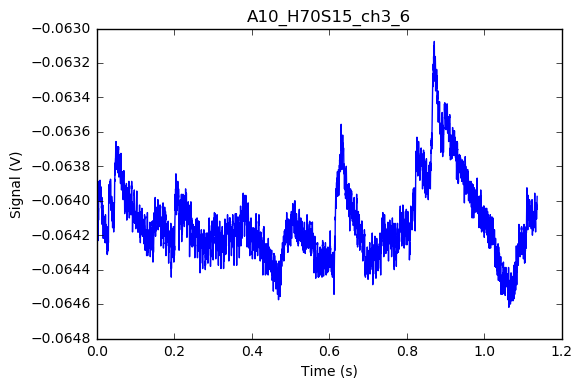

In [22]:
plt.plot(signal.times, signal)
plt.ylabel("Signal ({})".format(signal.units.dimensionality.string))
plt.xlabel("Time ({})".format(signal.times.units.dimensionality.string))
plt.title(signal.name)

## Extract the annotations

In [23]:
if signal.annotations['note']:
    annotations = dict(line.split("#") for line in signal.annotations['note'].strip().split("\r"))
else:
    annotations = {}

In [24]:
annotations

{}

## Export data to NWB format

In [25]:
%%capture
!pip install h5py
!pip install https://github.com/NeurodataWithoutBorders/api-python/archive/master.zip

In [26]:
from neo.io import NWBIO

Here we save a single trace into the NWB file. In practice, you would probably want to combine the data from all Igor Pro files in the zip archive into a single Neo block

In [27]:
io = NWBIO(local_path.replace(".ibw", ".nwb"))

In [28]:
block.segments[0].name = "Segment #0"  # workaround a bug in NWBIO

In [29]:
io.write(block)


******
Validation messages follow.
** 2 errors.
No Miscellaneous errors. -- Good
1 groups missing:
  1. '/processing/Units/UnitTimes/<unit_N>/'
1 datasets missing:
  1. '/processing/Units/UnitTimes/unit_list'
No attributes missing. -- Good
No Incorrect attribute values. -- Good
No groups custom missing attribute neurodata_type=Custom. -- Good
No datasets custom missing attribute neurodata_type=Custom. -- Good
No groups defined in extension, but missing attribute schema_id. -- Good
No datasets defined in extension, but missing attribute schema_id. -- Good
** 7 warnings.
No Miscellaneous warnings. -- Good
No groups custom inside custom missing attribute neurodata_type=Custom. -- Good
No datasets custom inside custom missing attribute neurodata_type=Custom. -- Good
No recommended groups missing. -- Good
5 recommended datasets missing:
  1. '/general/experiment_description'
  2. '/general/experimenter'
  3. '/general/institution'
  4. '/general/lab'
  5. '/general/session_id'
1 recommende

At this point, the exported NWB file fails validation. Development of the NWBIO is ongoing.

## Export data to NIX HDF5 format

An alternative HDF5-based format

In [34]:
%%capture
!pip install nixio

In [36]:
from neo.io import NixIO

In [38]:
io = NixIO(local_path.replace(".ibw", ".h5"), 'rw')

In [39]:
io.write(block)